In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter
from oma_tracking.data.utils import unpack_mode, get_frequencies, get_rated_data, get_parked_data, read_simulations_csv_files

In [231]:
start  = datetime.datetime(2012,1,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,19,tzinfo=utc)

location = 'bbc01'
name_location = 'BB_C01'

home_folder = "../../"
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/bb/raw/" + data_file_name + ".parquet"
data = pd.read_parquet(data_path)


SS1 = get_frequencies(data, 'SS1')
SS2 = get_frequencies(data, 'SS2')
FA1 = get_frequencies(data, 'FA1')

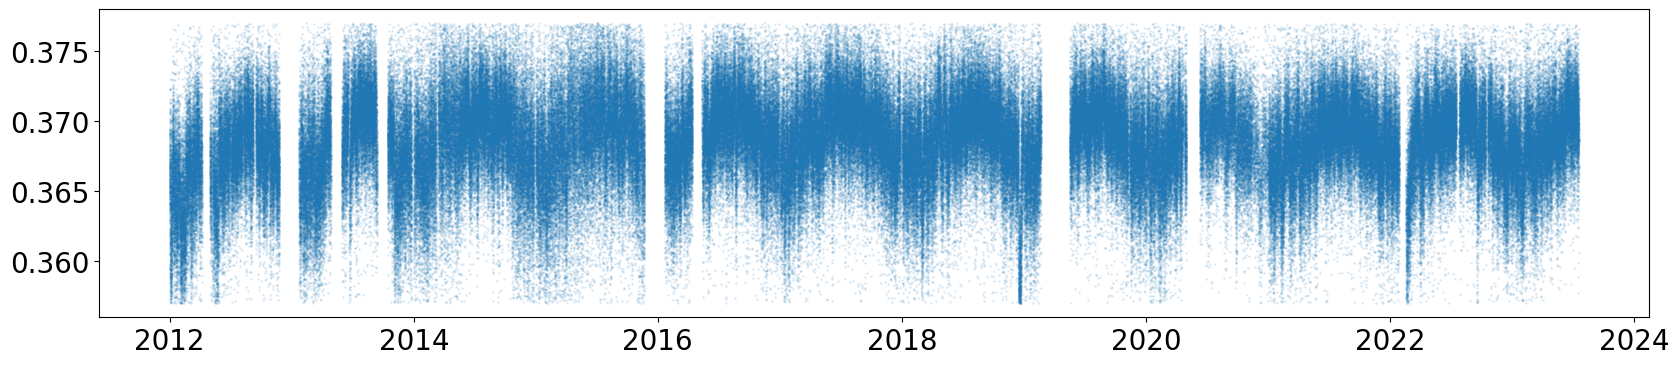

In [232]:
plt.figure(figsize = (20,4))
plt.scatter(SS1.index, SS1, s=1, alpha=0.1)
plt.show()

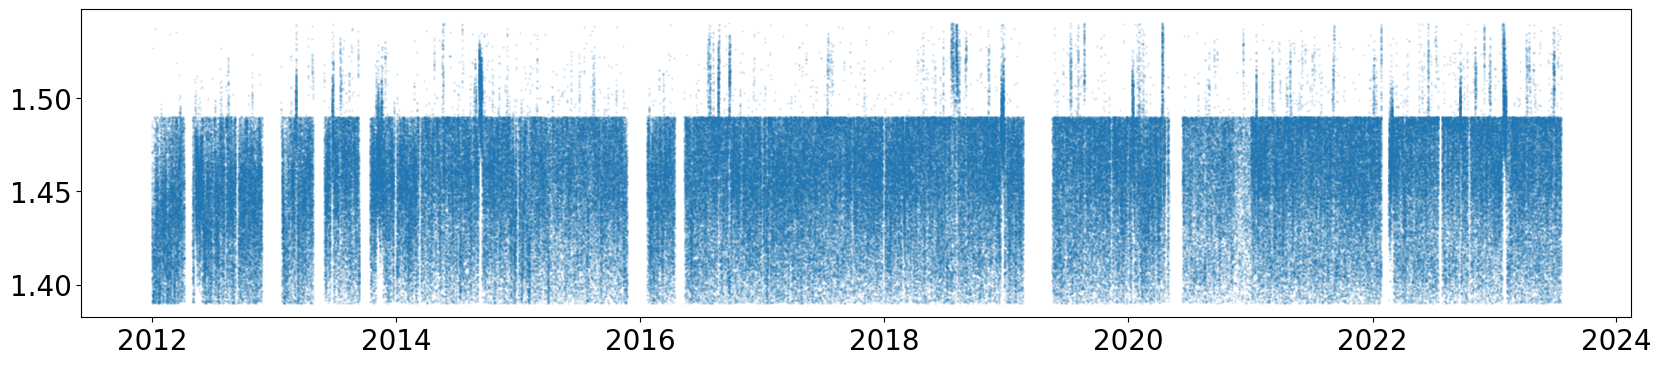

In [235]:
plt.figure(figsize = (20,4))
plt.scatter(SS2.index, SS2, s=1, alpha=0.1)
plt.show()

In [236]:
def get_parked_data(data):
    pitch = [col for col in data.columns if 'pitch' in col][0]
    parked_data = data[data[pitch] > 70]
    return parked_data

In [237]:
parked_data = get_parked_data(data)
parked_SS2 = get_frequencies(parked_data, 'SS2')
days = parked_SS2.groupby(parked_SS2.index.date).count()[parked_SS2.groupby(parked_SS2.index.date).count() > 144*0.2].dropna().index
parked_SS2['date'] = parked_SS2.index.date
parked_SS2_longterm = parked_SS2[np.isin(parked_SS2['date'], days)].drop(columns=['date'])

Text(0.5, 0, 'Count')

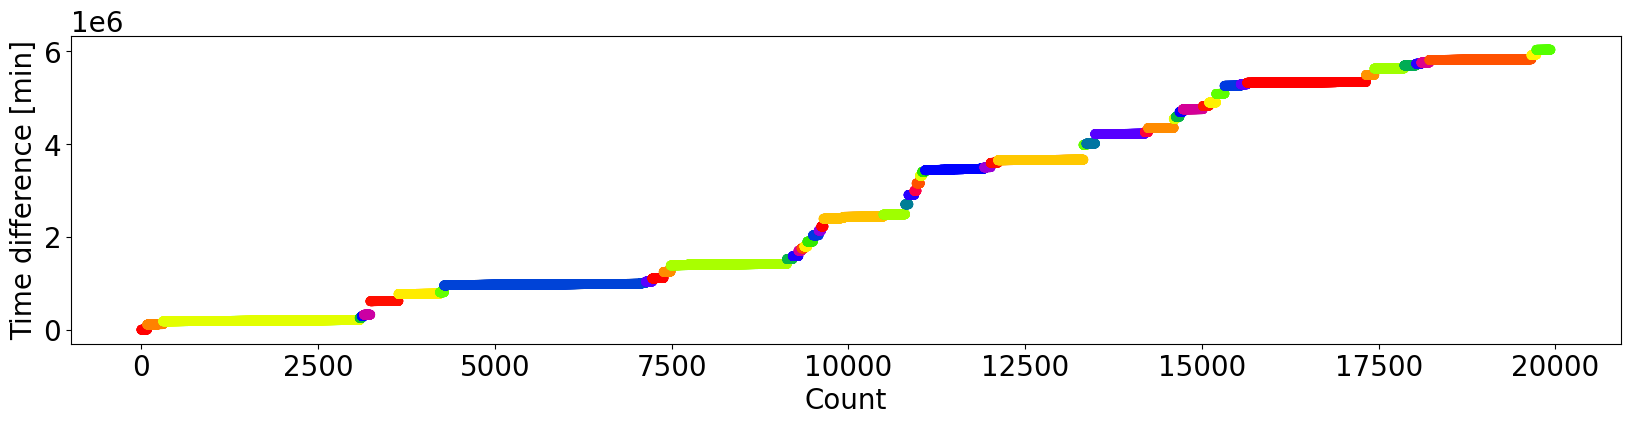

In [238]:
from sklearn.cluster import DBSCAN

time_difference = (parked_SS2_longterm.index-parked_SS2_longterm.index[0]).total_seconds()/60
parked_SS2_longterm['time_difference'] = time_difference
clustering = DBSCAN(eps=60*24*14, min_samples=2).fit(parked_SS2_longterm['time_difference'].values.reshape(-1, 1) )
parked_SS2_longterm['cluster'] = clustering.labels_
plt.figure(figsize = (20,4))
plt.scatter(range(len(time_difference)), time_difference, c=parked_SS2_longterm['cluster'], cmap='prism')
plt.ylabel('Time difference [min]')
plt.xlabel('Count')

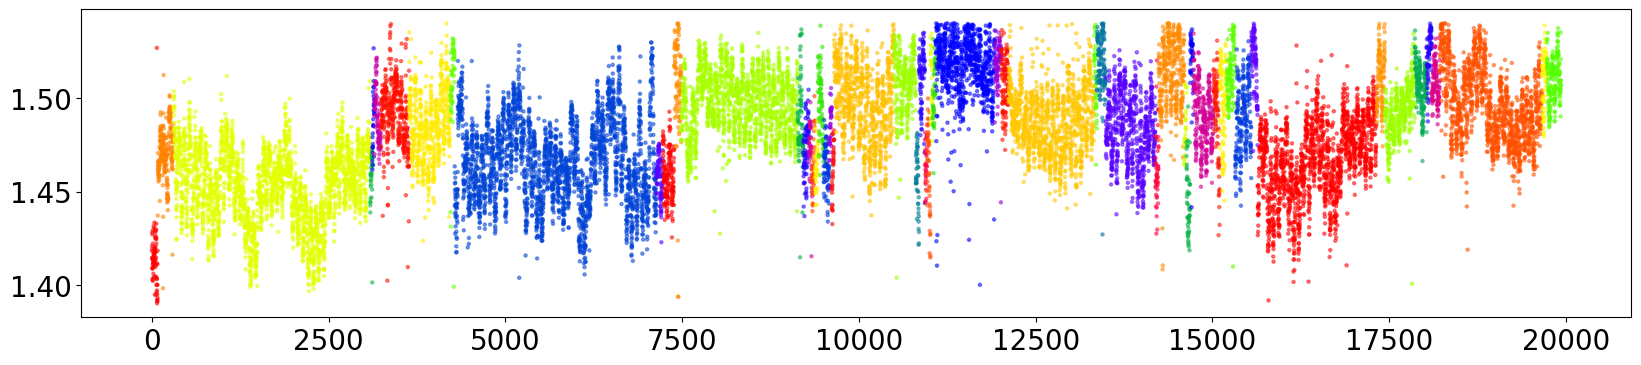

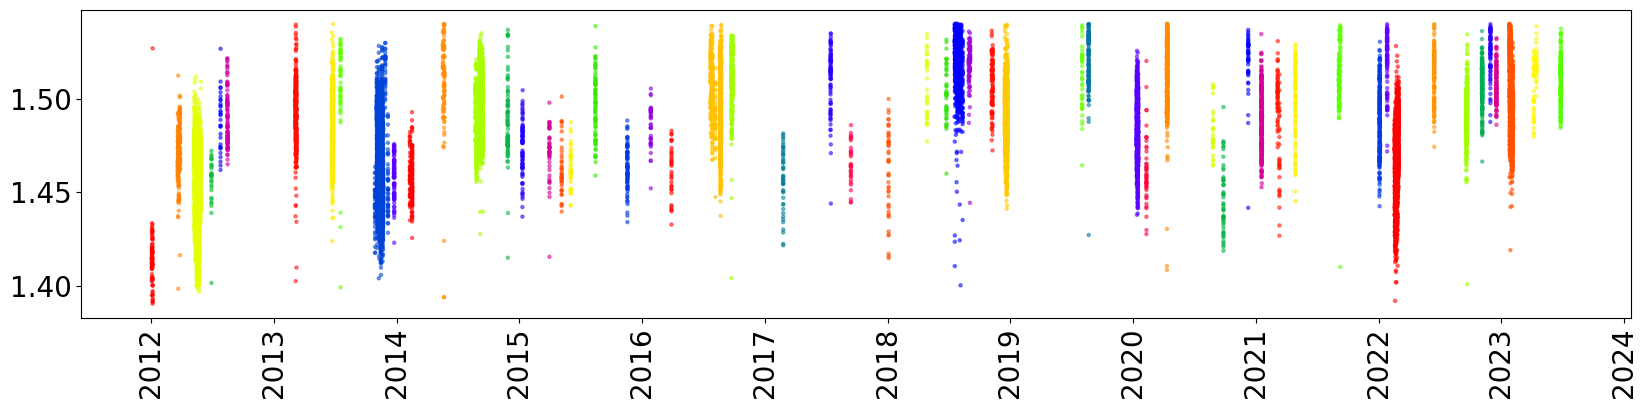

In [239]:
plt.figure(figsize = (20,4))
plt.scatter(range(len(parked_SS2_longterm)), parked_SS2_longterm['mean_frequency'].values, c=parked_SS2_longterm['cluster'].values, s=5, alpha=0.5, cmap='prism')
plt.show()
plt.figure(figsize = (20,4))
plt.scatter(parked_SS2_longterm.index, parked_SS2_longterm['mean_frequency'].values, c=parked_SS2_longterm['cluster'].values, s=5, alpha=0.5, cmap='prism')
# Get the current axes
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=90)
plt.show()

In [244]:
big_clusters = parked_SS2_longterm.groupby('cluster').count()[parked_SS2_longterm.groupby('cluster').count()>144].dropna().index
parked_SS2_longterm_big_clusters = parked_SS2_longterm[np.isin(parked_SS2_longterm['cluster'], big_clusters)]
unique_vals = parked_SS2_longterm_big_clusters['cluster'].unique()
parked_SS2_longterm_big_unique_clusters = parked_SS2_longterm_big_clusters['cluster'].replace(to_replace=unique_vals,
           value= list(range(len(unique_vals))),
           inplace=True)

C:\Users\Max\AppData\Local\Temp\ipykernel_26184\2350846599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parked_SS2_longterm_big_unique_clusters = parked_SS2_longterm_big_clusters['cluster'].replace(to_replace=unique_vals,


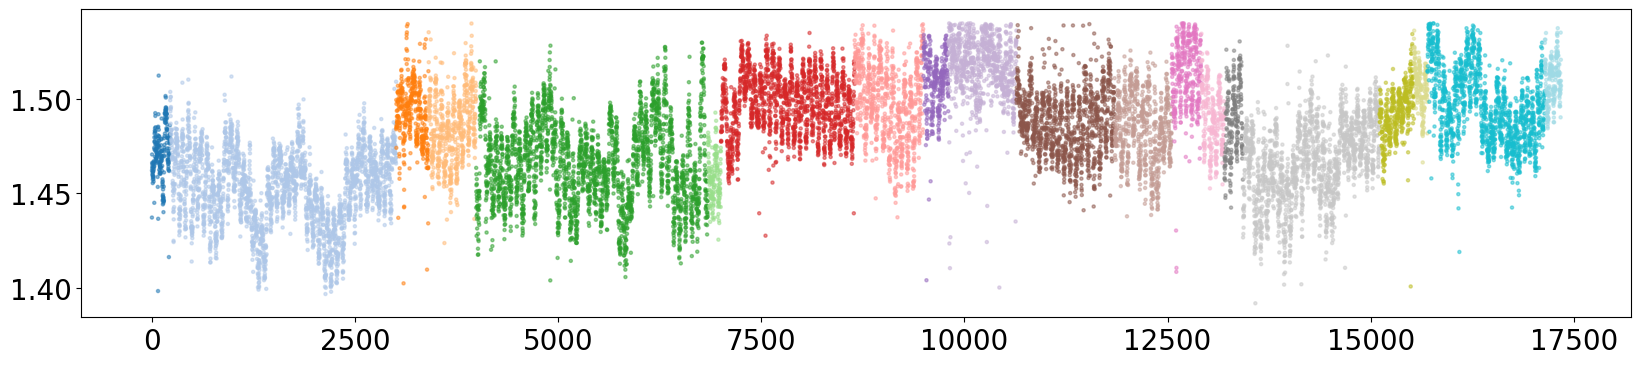

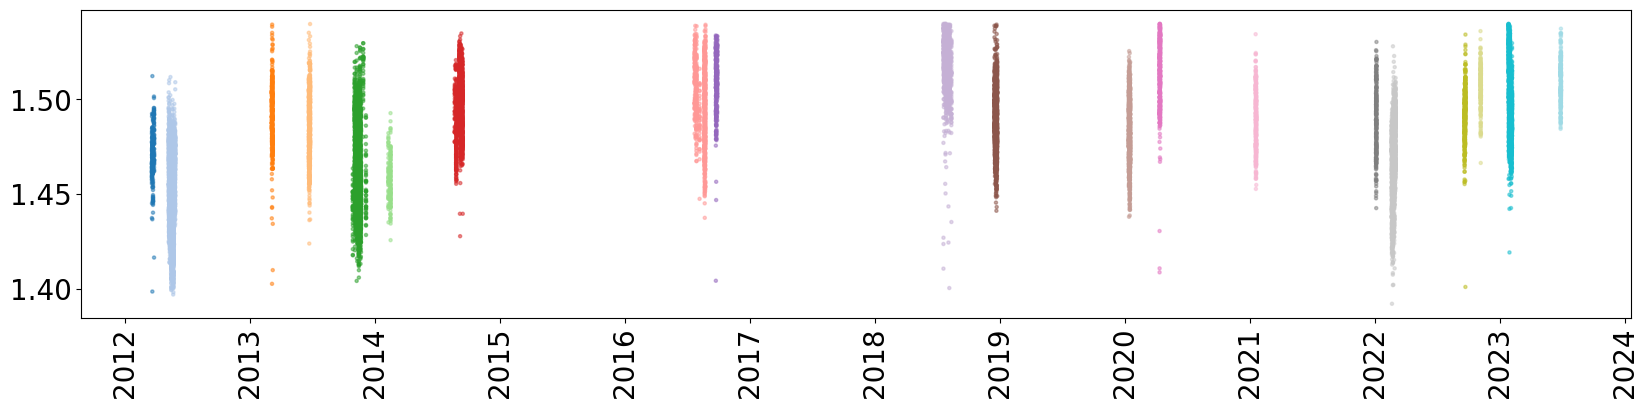

In [245]:
import matplotlib.dates as mdates

plt.figure(figsize = (20,4))
plt.scatter(range(len(parked_SS2_longterm_big_clusters)), parked_SS2_longterm_big_clusters['mean_frequency'].values, c=parked_SS2_longterm_big_clusters['cluster'].values, s=5, alpha=0.5, cmap='tab20')
plt.show()
plt.figure(figsize = (20,4))
plt.scatter(parked_SS2_longterm_big_clusters.index, parked_SS2_longterm_big_clusters['mean_frequency'].values, c=parked_SS2_longterm_big_clusters['cluster'].values, s=5, alpha=0.5, cmap='tab20')
# Get the current axes
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=90)
plt.show()

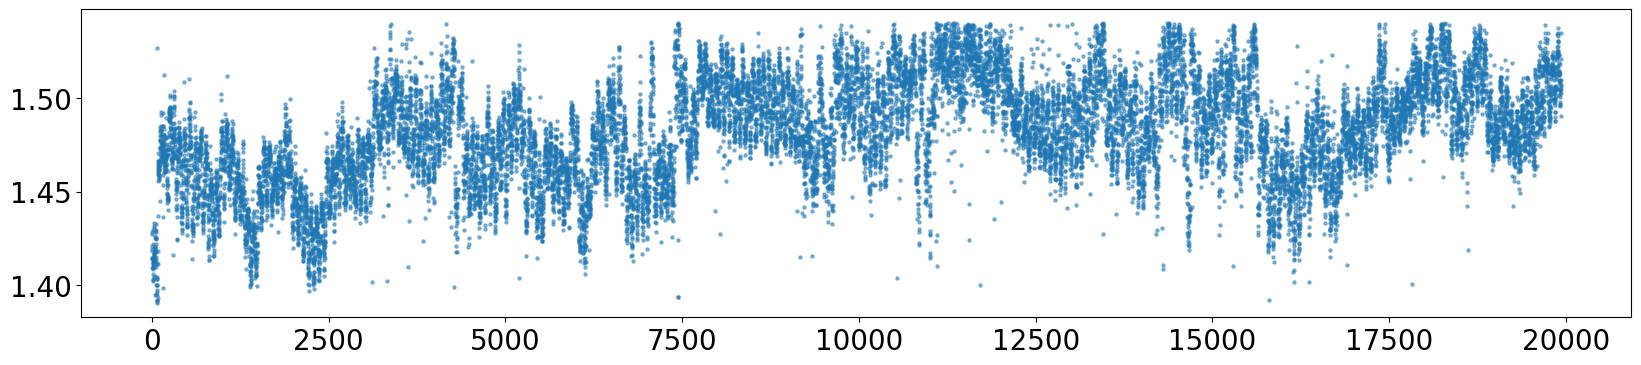

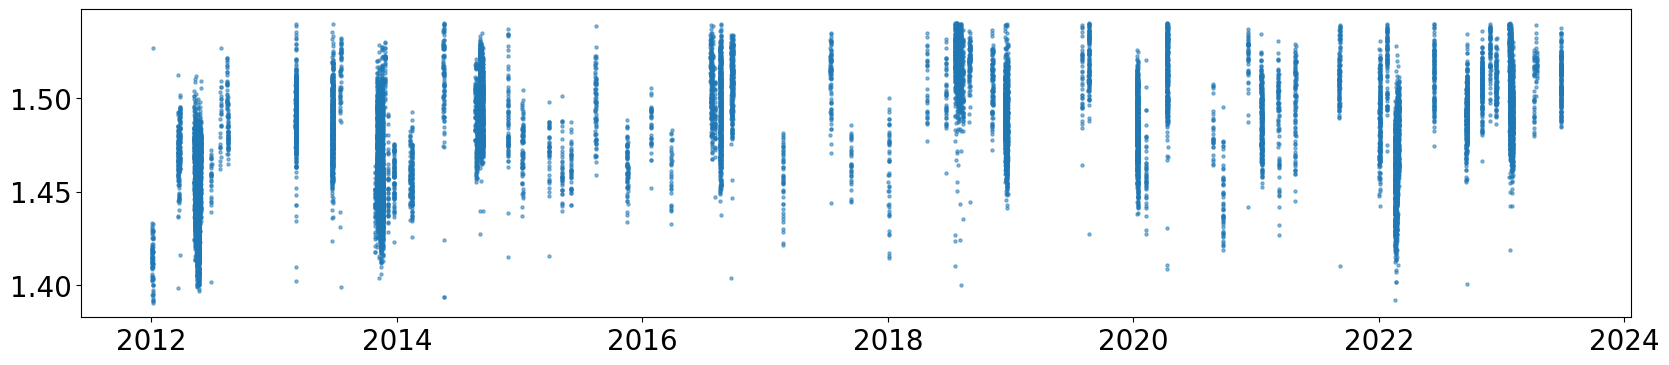

In [246]:
plt.figure(figsize = (20,4))
plt.scatter(range(len(parked_SS2_longterm)), parked_SS2_longterm['mean_frequency'], s=5, alpha=0.5)
plt.show()
plt.figure(figsize = (20,4))
plt.scatter(parked_SS2_longterm.index, parked_SS2_longterm['mean_frequency'], s=5, alpha=0.5)
plt.show()

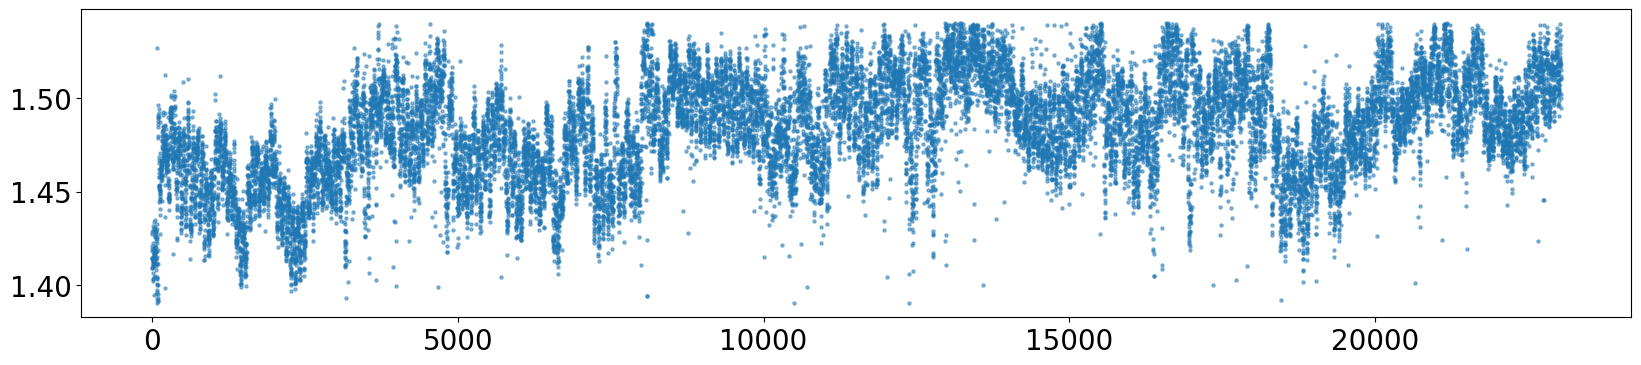

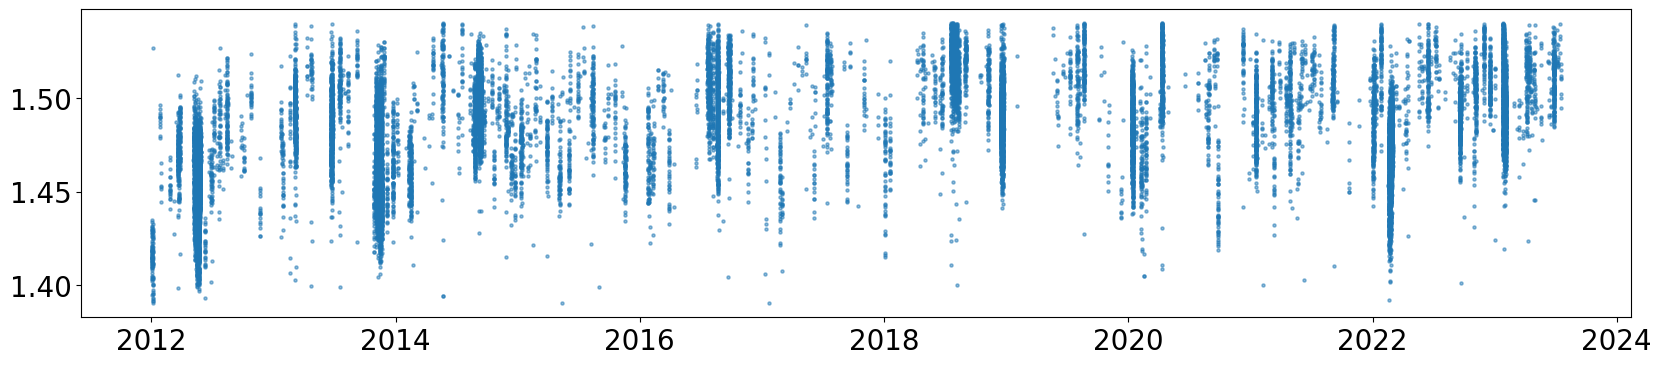

In [247]:
parked_data = get_parked_data(data)
parked_SS2 = get_frequencies(parked_data, 'SS2')
plt.figure(figsize = (20,4))
plt.scatter(range(len(parked_SS2)), parked_SS2, s=5, alpha=0.5)
plt.show()
plt.figure(figsize = (20,4))
plt.scatter(parked_SS2.index, parked_SS2, s=5, alpha=0.5)
plt.show()

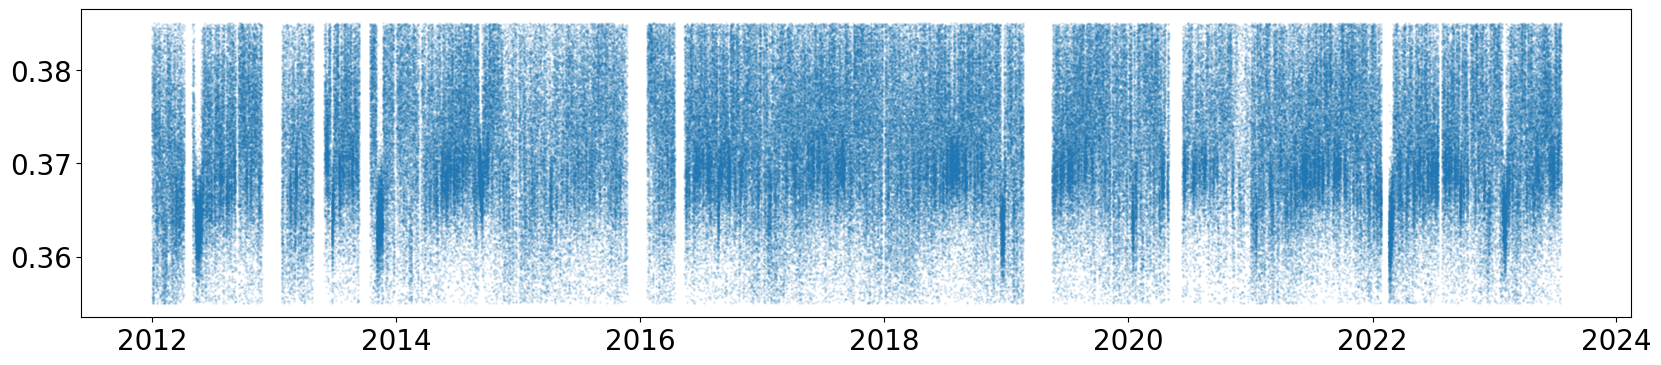

In [249]:
plt.figure(figsize = (20,4))
plt.scatter(FA1.index, FA1, s=1, alpha=0.1)
plt.show()

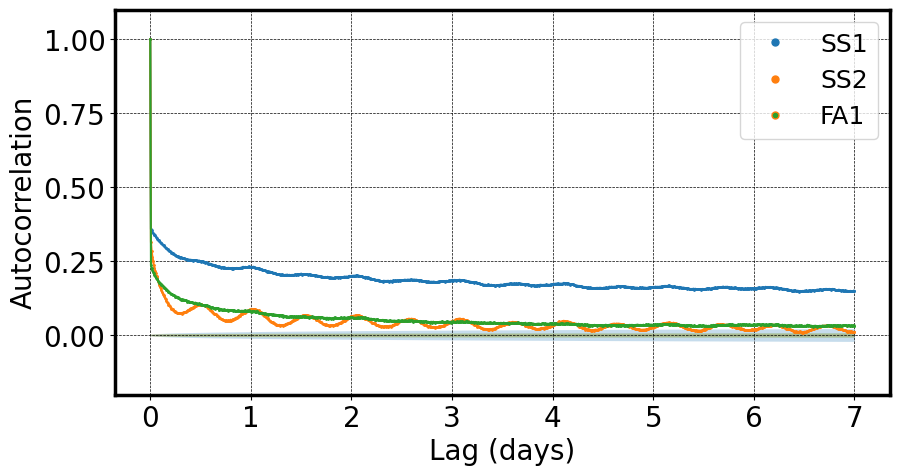

In [250]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import numpy as np

# Resample the series to fill missing indices and assign NaN values
resampled_SS1_frequency = SS1.resample('10min').asfreq()
resampled_SS2_frequency = SS2.resample('10min').asfreq()
resampled_FA1_frequency = FA1.resample('10min').asfreq()

resampled_freqyencies = pd.concat([resampled_SS1_frequency, resampled_SS2_frequency, resampled_FA1_frequency], axis=1)
resampled_freqyencies.columns = ['SS1', 'SS2', 'FA1']

# Calculate and plot autocorrelations
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(10, 5))
fig = plot_acf(resampled_SS1_frequency, missing='conservative', lags=7*144, ax=ax, 
        use_vlines=False, auto_ylims=True, markersize=1,
        alpha = 0.05, linestyle='-')

fig = plot_acf(resampled_SS2_frequency, missing='conservative', lags=7*144, ax=ax,
        use_vlines=False,auto_ylims=True, markersize=1,
        alpha = 0.05, linestyle='-')

fig = plot_acf(resampled_FA1_frequency, missing='conservative', lags=7*144, ax=ax,
        use_vlines=False,auto_ylims=True, markersize=1,
        alpha = 0.05, linestyle='-')

fig.set_size_inches(10, 5)
plt.ylim([-0.2, 1.1])
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.title('')

plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
# Increase the width of the spines
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['top'].set_linewidth(2.5)

# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

point1 = Line2D([0], [0], label='SS1', marker='o', markersize=5, 
         markeredgecolor='tab:blue', markerfacecolor='tab:blue', linestyle='')
point2 = Line2D([0], [0], label='SS2', marker='o', markersize=5, 
         markeredgecolor='tab:orange', markerfacecolor='tab:orange', linestyle='')
point3 = Line2D([0], [0], label='FA1', marker='o', markersize=5, 
         markeredgecolor='tab:orange', markerfacecolor='tab:green', linestyle='')

# add manual symbols to auto legend
handles.extend([point1, point2, point3])

plt.legend(handles=handles, fontsize=18, loc='upper right')
# Adjust the x-axis tick frequency
plt.xticks(np.arange(0, 8*144, 144), np.arange(0, 8, 1))
plt.show()

In [377]:
weather_data_path = "../../data/nw2/mvbc_data_longterm.parquet"
Thorntonbank_data_path = "../../data/nw2/Thorntonbank_data_longterm.parquet"
Westhinder_data_path = "../../data/nw2/Westhinder_data_longterm.parquet"

weather_data = pd.read_parquet(weather_data_path)

scada_inputs = data.filter(regex='mean')

In [378]:
weather_data.isna().sum()

mvbc_WandelaarBuoy_10%_highest_waves                                     30934
mvbc_WandelaarBuoy_Wave_height                                           30934
mvbc_WandelaarBuoy_Average_wave_period                                   31726
mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s                       38243
mvbc_WandelaarMeasuringpile_Sea_water_temperature                       291615
mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)    122115
mvbc_WandelaarMeasuringpile_Average_wind_direction                       39781
mvbc_WandelaarMeasuringpile_Tide_TAW                                     41799
mvbc_WandelaarMeasuringpile_Air_pressure                                 49001
mvbc_WandelaarMeasuringpile_Flow_direction_cell_3                       344615
mvbc_WandelaarBuoy_1%_wave_height                                       307142
mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)         122178
mvbc_WandelaarMeasuringpile_Air_temperature         

In [379]:
inputs = \
    pd.concat(
        [
            weather_data,
            scada_inputs
        ],
        axis=1
    )

selected_columns = \
    [
       #'mvbc_WandelaarBuoy_10%_highest_waves',
       #'mvbc_WandelaarBuoy_Wave_height',
       #'mvbc_WandelaarBuoy_Average_wave_period',
       #'mvbc_WandelaarMeasuringpile_Tide_TAW',
       #'mvbc_WandelaarMeasuringpile_Air_pressure',
       #'mvbc_WandelaarMeasuringpile_Air_temperature',
       #'mvbc_Wandelaar_Sea_water_temperature',
       'Sea_water_temperature',
       'Wave_height',
       'Tide_TAW',
       'Average_wave_period',
       'mean_'+ name_location + '_rpm',
       'mean_'+ name_location + '_yaw',
       'mean_'+ name_location + '_pitch',
       'mean_'+ name_location + '_power',
       'mean_'+ name_location + '_windspeed',
       'mean_'+ name_location + '_winddirection'
    ]
inputs = inputs[selected_columns]

In [380]:
inputs.isna().sum()

Sea_water_temperature         6801
Wave_height                   2896
Tide_TAW                      2896
Average_wave_period           2896
mean_BB_C01_rpm              25254
mean_BB_C01_yaw              25255
mean_BB_C01_pitch            25254
mean_BB_C01_power            28386
mean_BB_C01_windspeed        25267
mean_BB_C01_winddirection    25254
dtype: int64

In [444]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs

# Transform the input data
angle_transformed_inputs = sin_cos_angle_inputs(inputs)
angle_columns = [angle for angle in inputs.columns if ('yaw' in angle or 'winddirection' in angle)]
angle_removed_inputs = inputs.drop(columns=angle_columns)

# Split the data into input features (X) and target variable (y)
y = SS1.dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
print(X.shape, y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)


(504647, 12) (504647, 1)


In [445]:
xgb_regr = xgb.XGBRegressor()
xgb_regr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [432]:
predictions = xgb_regr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print('MSE: ', mse, 'MAE: ', mae, 'R2: ', r2)

MSE:  8.23971487154774e-06 MAE:  0.002235214180341241 R2:  0.1345424079177201


C:\Users\Max\AppData\Local\Temp\ipykernel_26184\3376402041.py:7: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


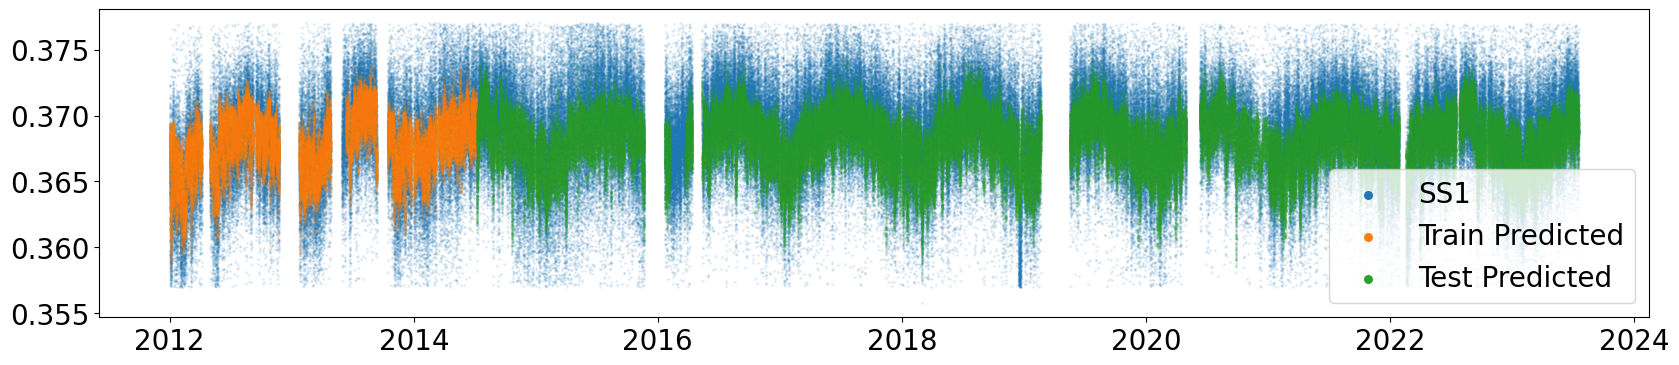

In [433]:
predict_train = xgb_regr.predict(X_train)
plt.figure(figsize = (20,4))
plt.scatter(SS1.index, SS1 , label='SS1', alpha=0.1, s=1)
plt.scatter(y_train.index, predict_train, label='Train Predicted', alpha=0.1, s=1)
plt.scatter(y_test.index, predictions, label='Test Predicted', alpha=0.1, s=1)
legend = plt.legend()
for handle in legend.legendHandles:
    handle.set_alpha(1.0)
    handle.set_sizes([30.0])
plt.show()

C:\Users\Max\AppData\Local\Temp\ipykernel_26184\2403696829.py:8: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


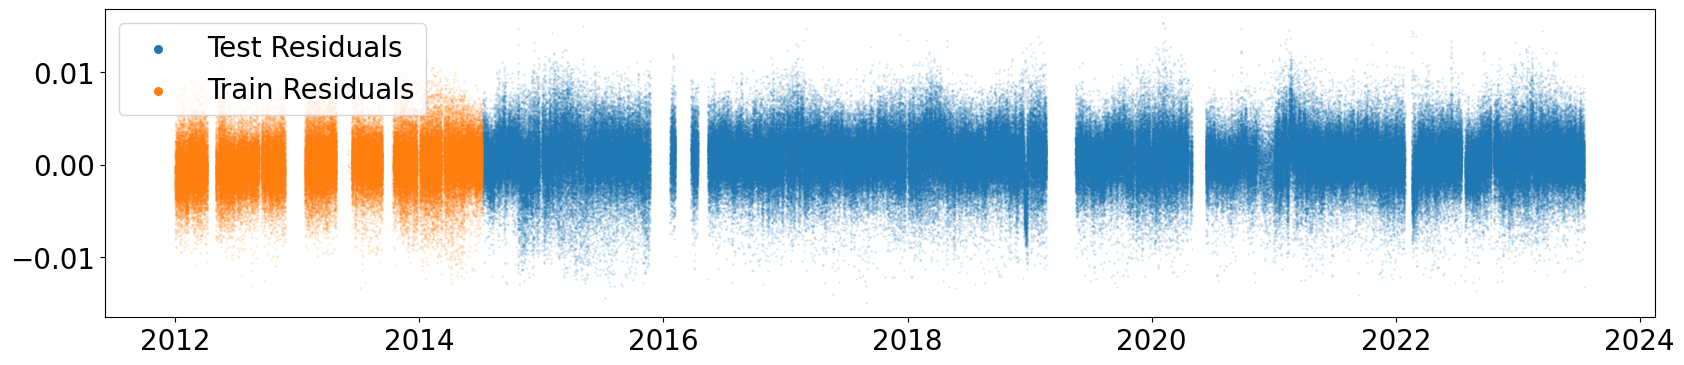

In [434]:
residuals_test = y_test.values[:,0] - predictions
residuals_train = y_train.values[:,0] - predict_train

plt.figure(figsize = (20,4))
plt.scatter(y_test.index, residuals_test, label='Test Residuals', alpha=0.1, s=1)
plt.scatter(y_train.index, residuals_train, label='Train Residuals', alpha=0.1, s=1)
legend = plt.legend()
for handle in legend.legendHandles:
    handle.set_alpha(1.0)
    handle.set_sizes([30.0])
plt.show()

(504647, 12) (504647, 1)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


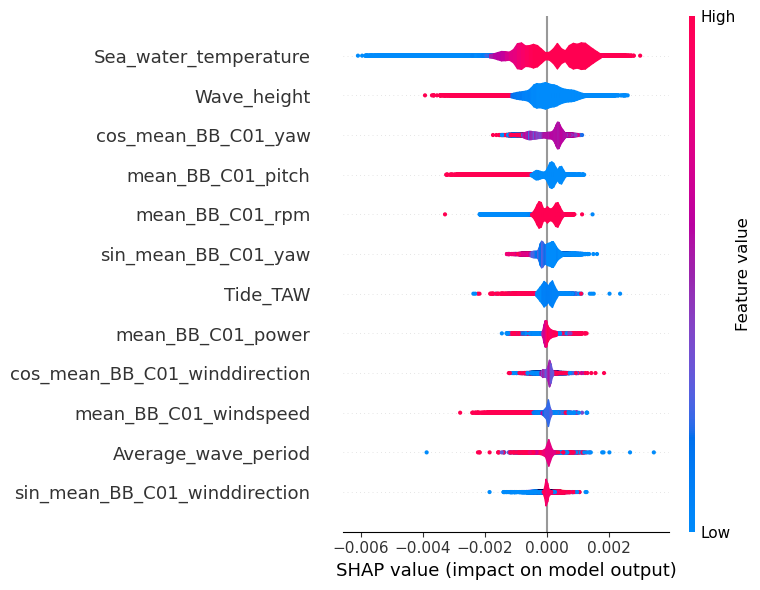

In [448]:
import shap

# Split the data into input features (X) and target variable (y)
y = SS1.dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
print(X.shape, y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

xgb_regr = xgb.XGBRegressor()
xgb_regr.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_regr)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="violin")

# SS2 parked regression

(17249, 12) (17249,)
MSE:  0.0007559837718288252 MAE:  0.023020245102595246 R2:  -0.2096205920115508


C:\Users\Max\AppData\Local\Temp\ipykernel_26184\116382986.py:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


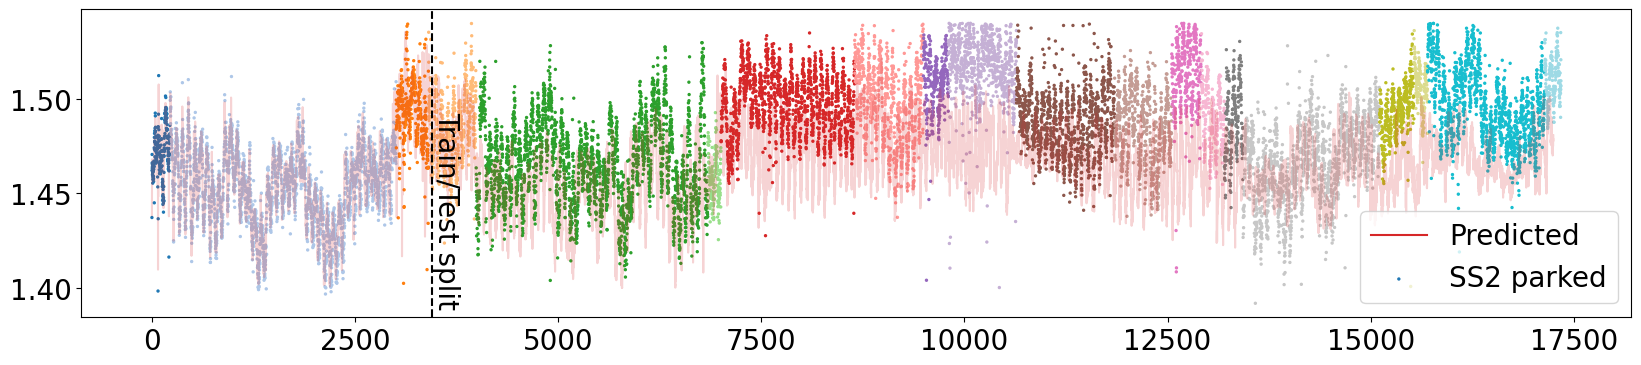

C:\Users\Max\AppData\Local\Temp\ipykernel_26184\116382986.py:51: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


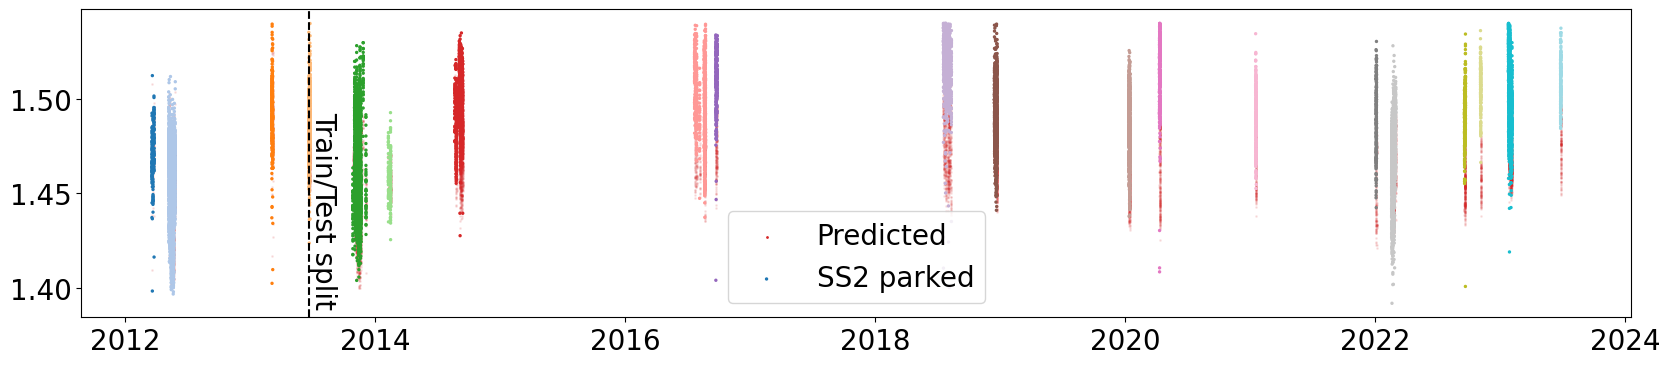

In [435]:
# Split the data into input features (X) and target variable (y)
y = parked_SS2_longterm_big_clusters['mean_frequency'].dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
print(X.shape, y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

xgb_regr = xgb.XGBRegressor()
xgb_regr.fit(X_train, y_train)

predictions = xgb_regr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print('MSE: ', mse, 'MAE: ', mae, 'R2: ', r2)

predict_train = xgb_regr.predict(X)

plt.figure(figsize = (20,4))
plt.plot(range(len(y)), predict_train, label='Predicted', color='tab:red', alpha=0.2)
tab20 = plt.get_cmap('tab20')
first_colors = tab20(range(0,len(parked_SS2_longterm_big_clusters['cluster'].unique()),1))
cmap = ListedColormap(first_colors)
plt.scatter(
    range(len(parked_SS2_longterm_big_clusters)),
    parked_SS2_longterm_big_clusters['mean_frequency'],
    label='SS2 parked',
    alpha=1.0, s=2,
    c=parked_SS2_longterm_big_clusters['cluster'], cmap=cmap)
legend = plt.legend()
for handle in legend.legendHandles:
    handle.set_alpha(1.0)
plt.axvline(x=len(X_train), color='k', linestyle='--')
plt.text(len(X_train), min(y), 'Train/Test split', rotation=-90)
plt.show()

plt.figure(figsize = (20,4))
plt.scatter(y.index, predict_train, label='Predicted', color='tab:red', alpha=0.1, s=1)
tab20 = plt.get_cmap('tab20')
first_colors = tab20(range(0,len(parked_SS2_longterm_big_clusters['cluster'].unique()),1))
cmap = ListedColormap(first_colors)
plt.scatter(
    parked_SS2_longterm_big_clusters.index,
    parked_SS2_longterm_big_clusters['mean_frequency'],
    label='SS2 parked',
    alpha=1.0, s=2,
    c=parked_SS2_longterm_big_clusters['cluster'], cmap=cmap)
legend = plt.legend()
for handle in legend.legendHandles:
    handle.set_alpha(1.0)
plt.axvline(x=parked_SS2_longterm_big_clusters.index[len(X_train)], color='k', linestyle='--')
plt.text(parked_SS2_longterm_big_clusters.index[len(X_train)], min(y), 'Train/Test split', rotation=-90)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


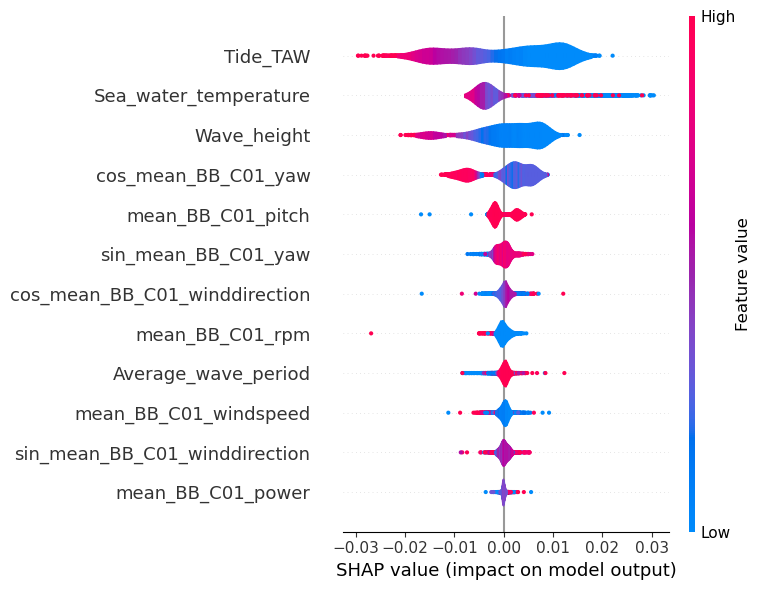

In [447]:
import shap

# Split the data into input features (X) and target variable (y)
y = parked_SS2_longterm_big_clusters['mean_frequency'].dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
print(X.shape, y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

xgb_regr = xgb.XGBRegressor()
xgb_regr.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_regr)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="violin")


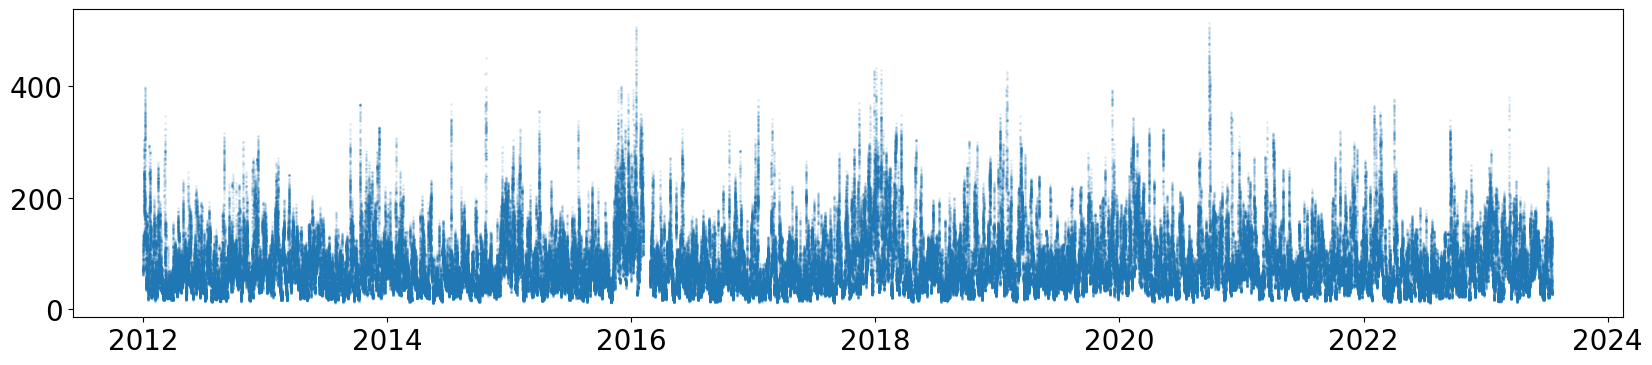

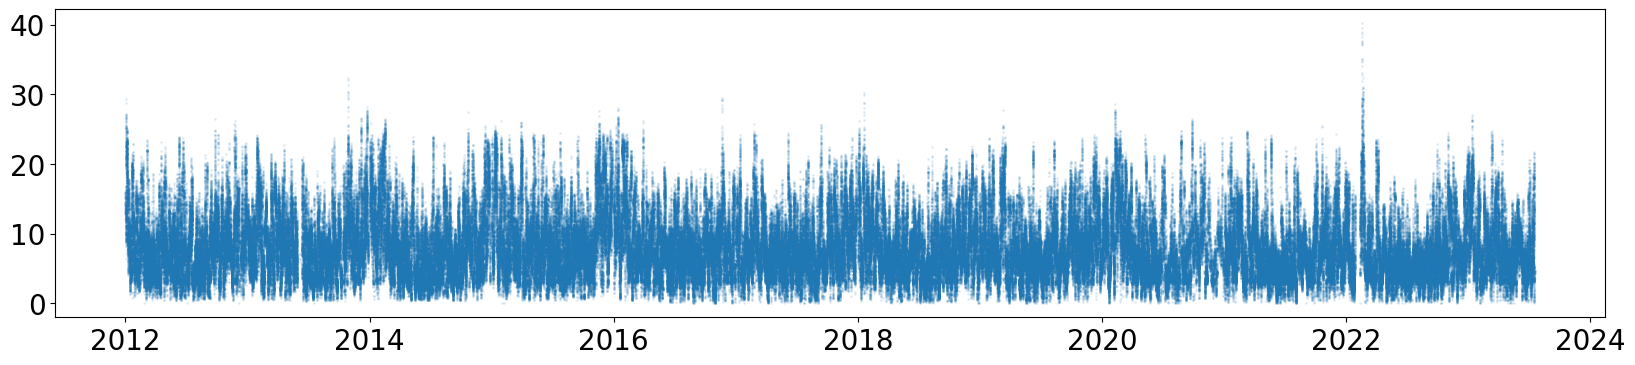

In [438]:
plt.figure(figsize = (20,4))
plt.scatter(inputs.index, inputs['Wave_height'], s=1, alpha=0.1)
plt.show()
plt.figure(figsize = (20,4))
plt.scatter(inputs.index, inputs['mean_BB_C01_windspeed'], s=1, alpha=0.1)